In [1]:
from riskeye.cogmodels.fit_probit import build_model, get_data
import arviz as az
from riskeye.cogmodels.utils import extract_intercept_gamma, get_rnp, format_bambi_ppc
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def get_info(model_label, bids_folder='/data/ds-riskeye'):
    df = get_data(model_label, bids_folder=bids_folder)
    model = build_model(model_label, df)
    idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels/model-{model_label}_trace.netcdf'))

    intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
    rnp = get_rnp(intercept, gamma)

    # for x in [df, gamma, rnp]:
    #     x['Experiment'] = x.index.get_level_values('exptype').map({'symbolic':'Symbols', 'non-symbolic':'Coin clouds'})
    #     x.set_index('Experiment', append=True, inplace=True)

    return df, model, idata, gamma, rnp

# Probit 0

In [3]:
model_label = 'probit0'
df, model, idata, gamma, rnp = get_info(model_label)

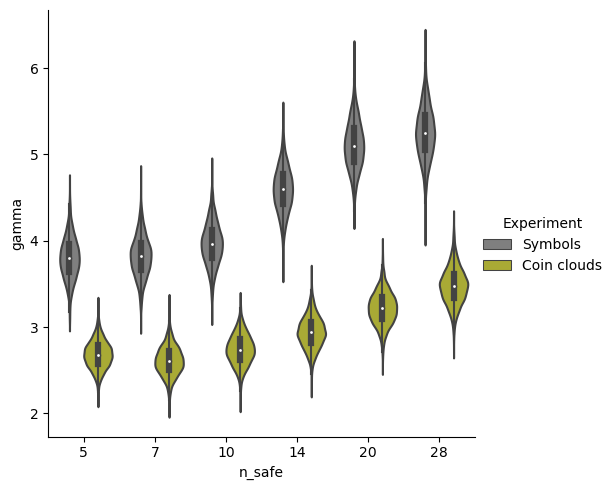

In [ ]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', hue='Experiment', kind='violin', palette=sns.color_palette()[-3:])

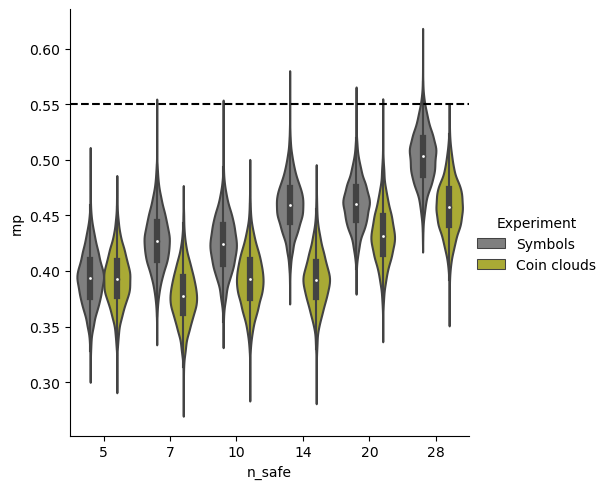

In [ ]:
sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', hue='Experiment', kind='violin', palette=sns.color_palette()[-3:])
plt.axhline(0.55, c='k', ls='--')

In [6]:
ppc = format_bambi_ppc(idata.sel(draw=slice(None, None, 20)), model, df)

In [7]:
ppc

chain                                                                                                                                                                                                                                                       0  \
draw                                                                                                                                                                                                                                                      0     
variable     subject run exptype      block trial accuracy rt    leftRight pressedKey n_safe n_risky constSide correct_perm reset onset   n_left n_right p_left p_right chose_risky log(risky/safe) bin(risky/safe) Experiment  x        log_n_safe             
ll_bernoulli 01      1   symbolic     1     1     1        1.215  1        75         14     47      0         -1           -1    6.065   47     14      0.55   1.00    1.0         1.211090        5.0             Symbols     1.211090 2.639057    1.000000   
                                            2     1        0.737 -1        77         5      6       0          1           -1    11.708  6      5       0.55   1.00    0.0         0.182322        1.0             Symbols     0.182322 1.609438    0.000000   
                                            3     1        0.920 -1        77         14     17      0          1           -1    17.284  17     14      0.55   1.00    0.0         0.194156        2.0             Symbols     0.194156 2.639057    0.000000   
                                            4     1        0.965 -1        77         10     12      0          1           -1    22.882  12     10      0.55   1.00    0.0         0.182322        1.0             Symbols     0.182322 2.302585    0.000000   
                                            5     1        1.218  1        75         14     28      0         -1           -1    28.471  28     14      0.55   1.00    1.0         0.693147        3.0             Symbols     0.693147 2.639057    1.000000   
...                                                                                                                                                                                                                                                       ...   
p            64      5   non-symbolic 2     20    1        0.674  1        75         14     15      0          1            1    248.035 14     15      1.00   0.55    0.0         0.068993        1.0             Coin clouds 0.068993 2.639057    0.003974   
                                            21    0        0.915  1        75         5      12      0         -1            1    253.570 5      12      1.00   0.55    0.0         0.875469        4.0             Coin clouds 0.875469 1.609438    0.105568   
                                            22    1        0.669  1        75         10     12      0          1            1    259.087 10     12      1.00   0.55    0.0         0.182322        1.0             Coin clouds 0.182322 2.302585    0.002929   
                                            23    1        0.822 -1        77         5      20      0         -1            1    264.623 5      20      1.00   0.55    1.0         1.386294        6.0             Coin clouds 1.386294 1.609438    0.253859   
                                            24    1        1.015  1        75         20     22      0          1            1    270.161 20     22      1.00   0.55    0.0         0.095310        1.0             Coin clouds 0.095310 2.995732    0.002925   

chain                                                                                                                                                                                                                                                          \
draw                                                                                                                                            

In [8]:
df

accuracy     rt  leftRight  pressedKey  \
subject run exptype      block trial                                           
01      1   symbolic     1     1             1  1.215          1          75   
                               2             1  0.737         -1          77   
                               3             1  0.920         -1          77   
                               4             1  0.965         -1          77   
                               5             1  1.218          1          75   
...                                        ...    ...        ...         ...   
64      5   non-symbolic 2     20            1  0.674          1          75   
                               21            0  0.915          1          75   
                               22            1  0.669          1          75   
                               23            1  0.822         -1          77   
                               24            1  1.015          1          75   

                                      n_safe  n_risky  constSide  \
subject run exptype      block trial                               
01      1   symbolic     1     1          14       47          0   
                               2           5        6          0   
                               3          14       17          0   
                               4          10       12          0   
                               5          14       28          0   
...                                      ...      ...        ...   
64      5   non-symbolic 2     20         14       15          0   
                               21          5       12          0   
                               22         10       12          0   
                               23          5       20          0   
                               24         20       22          0   

                                      correct_perm  reset    onset  n_left  \
subject run exptype      block trial                                         
01      1   symbolic     1     1                -1     -1    6.065      47   
                               2                 1     -1   11.708       6   
                               3                 1     -1   17.284      17   
                               4                 1     -1   22.882      12   
                               5                -1     -1   28.471      28   
...                                            ...    ...      ...     ...   
64      5   non-symbolic 2     20                1      1  248.035      14   
                               21               -1      1  253.570       5   
                               22                1      1  259.087      10   
                               23               -1      1  264.623       5   
                               24                1      1  270.161      20   

                                      n_right  p_left  p_right  chose_risky  \
subject run exptype      block trial                                          
01      1   symbolic     1     1           14    0.55     1.00          1.0   
                               2            5    0.55     1.00          0.0   
                               3           14    0.55     1.00          0.0   
                               4           10    0.55     1.00          0.0   
                               5           14    0.55     1.00          1.0   
...                                       ...     ...      ...          ...   
64      5   non-symbolic 2     20          15    1.00     0.55          0.0   
                               21          12    1.00     0.55          0.0   
                               22          12    1.00     0.55          0.0   
                               23          20    1.00     0.55          1.0   
                               24          22    1.00     0.55          0.0   

                                      log(risky/safe)  bin(risky/safe

In [65]:
from riskeye.cogmodels.utils import cluster_offers, summarize_ppc, plot_prediction

def plot_ppc(df, ppc, plot_type=1, var_name='ll_bernoulli', level='subject', col_wrap=5, legend=True, **kwargs):

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()

    df = df.copy()

    # Make sure that we group data from (Roughly) same fractions
    if not (df.groupby(['subject', 'log(risky/safe)']).size().groupby('subject').size() < 7).all():
        df['log(risky/safe)'] = df.groupby(['subject'],
                                        group_keys=False).apply(cluster_offers)

    if level == 'group':
        df['log(risky/safe)'] = df['bin(risky/safe)']
        ppc = ppc.reset_index('log(risky/safe)')
        ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')

    if plot_type == 0:
        groupby = ['log(risky/safe)', 'Experiment']
    elif plot_type == 1:
        groupby = ['n_safe', 'Experiment']
    elif plot_type in [2, 4]:
        groupby = ['risky_first', 'n_safe']
    elif plot_type in [3, 5]:
        groupby = ['risky_first', 'n_safe', 'log(risky/safe)']
    elif plot_type in [6]:
        groupby = ['risky_first', 'n_safe', 'exptype']
    else:
        raise NotImplementedError

    print(groupby, level, ppc.head())
    if level == 'group':
        ppc = ppc.groupby(['subject']+groupby).mean()
        print('*** yooo')
        print(ppc.head())

    if level == 'subject':
        groupby = ['subject'] + groupby

    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    print(ppc_summary)
    p = df.groupby(groupby)[['chose_risky']].mean()
    ppc_summary = ppc_summary.join(p).reset_index()

    print(ppc_summary)

    if 'risky_first' in ppc_summary.columns:
        ppc_summary['Order'] = ppc_summary['risky_first'].map({True:'Risky first', False:'Safe first'})

    if 'n_safe' in groupby:
        ppc_summary['Safe offer'] = ppc_summary['n_safe'].astype(int)

    ppc_summary['Prop. chosen risky'] = ppc_summary['chose_risky']

    if 'log(risky/safe)' in groupby:
        if level == 'group':
            ppc_summary['Predicted acceptance'] = ppc_summary['log(risky/safe)']
        else:
            ppc_summary['Log-ratio offer'] = ppc_summary['log(risky/safe)']

    if plot_type in [1, 6]:
        x = 'Safe offer'
    else:
        if level == 'group':
            x = 'Predicted acceptance'
        else:
            x = 'Log-ratio offer'


    if plot_type in [0]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='Experiment',
                            col_wrap=col_wrap if level == 'subject' else None,
                            hue_order=['Symbols', 'Coin clouds'],
                            palette=sns.color_palette()[-3:],
                            **kwargs)


    elif plot_type in [1]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='Experiment',
                            hue_order=['Symbols', 'Coin clouds'],
                            palette=sns.color_palette()[-3:],
                            col_wrap=col_wrap if level == 'subject' else None,
                            **kwargs)

    elif plot_type == 3:
        fac = sns.FacetGrid(ppc_summary,
                            col='Safe offer',
                            hue='Order',
                            row='subject' if level == 'subject' else None,
                            **kwargs)
    elif plot_type == 4:


        if level == 'group':
            rnp = df.groupby(['subject'] + groupby, group_keys=False).apply(get_rnp).to_frame('rnp')
            rnp = rnp.groupby(groupby).mean()
        else:
            rnp = df.groupby(groupby, group_keys=False).apply(get_rnp).to_frame('rnp')

        ppc_summary = ppc_summary.join(rnp)
        fac = sns.FacetGrid(ppc_summary,
                            hue='Order',
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None,
                            **kwargs)

        fac.map_dataframe(plot_prediction, x='Safe offer', y='p_predicted')
        fac.map(plt.scatter, 'Safe offer', 'rnp')
        fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))

    elif plot_type == 5:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='Safe offer',
                            row='subject' if level == 'subject' else None,
                            palette='coolwarm',
                            **kwargs)

    elif plot_type == 6:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='exptype',
                            hue_order=['vertex', 'ips'],
                            row='subject' if level == 'subject' else None,
                            palette=sns.color_palette()[2:],
                            **kwargs)


    if plot_type in [0, 1,2,3, 5, 6]:
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'Prop. chosen risky')
        fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

    if plot_type in [0, 3, 5]:
        if level == 'subject':
            fac.map(lambda *args, **kwargs: plt.axvline(np.log(1./.55), c='k', ls='--'))
        else:
            fac.map(lambda *args, **kwargs: plt.axvline(3.5, c='k', ls='--'))

    
    if legend:
        fac.add_legend()

    return fac

In [66]:
groupby = ['n_safe', 'Experiment']
ppc_ = ppc.groupby(['subject']+groupby).mean()
ppc_summary = summarize_ppc(ppc, groupby=groupby)
# ppc_summary
ppc_summary

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:88: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


p_predicted    hdi025    hdi975
n_safe Experiment                                  
5      Coin clouds     0.364313  0.350600  0.377269
       Symbols         0.342420  0.330582  0.355413
7      Coin clouds     0.338708  0.324906  0.353243
       Symbols         0.400860  0.385961  0.412583
10     Coin clouds     0.355561  0.345095  0.370961
       Symbols         0.387650  0.377580  0.398404
14     Coin clouds     0.344561  0.332085  0.355828
       Symbols         0.422547  0.413333  0.432899
20     Coin clouds     0.412117  0.400119  0.423129
       Symbols         0.430837  0.416514  0.441328
28     Coin clouds     0.431377  0.417020  0.442568
       Symbols         0.494457  0.482383  0.504820

['n_safe', 'Experiment'] group chain                                                                                                                                                                                                            log(risky/safe)  \
draw                                                                                                                                                                                                                               
subject run exptype  block trial accuracy rt    leftRight pressedKey n_safe n_risky constSide correct_perm reset onset  n_left n_right p_left p_right chose_risky bin(risky/safe) Experiment x        log_n_safe                   
01      1   symbolic 1     1     1        1.215  1        75         14     47      0         -1           -1    6.065  47     14      0.55   1.0     1.0         5.0             Symbols    1.211090 2.639057               5.0   
                           2     1        0.737 -1       

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:88: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


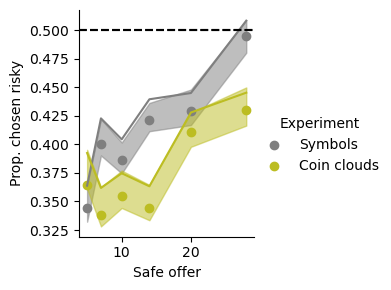

In [67]:
g = plot_ppc(df, ppc, level='group', plot_type=1, var_name='ll_bernoulli')
# g.set(xticks=[], xlabel='Choice bin')

['log(risky/safe)', 'Experiment'] group chain                                                                                                                                                                                                            log(risky/safe)  \
draw                                                                                                                                                                                                                               
subject run exptype  block trial accuracy rt    leftRight pressedKey n_safe n_risky constSide correct_perm reset onset  n_left n_right p_left p_right chose_risky bin(risky/safe) Experiment x        log_n_safe                   
01      1   symbolic 1     1     1        1.215  1        75         14     47      0         -1           -1    6.065  47     14      0.55   1.0     1.0         5.0             Symbols    1.211090 2.639057               5.0   
                           2     1        0.737 

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_51804/2398338099.py:36: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:88: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


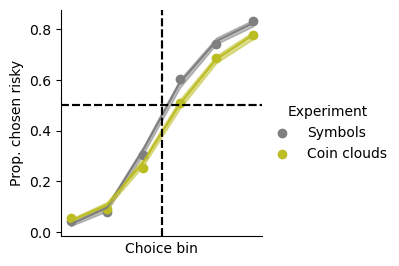

In [68]:
g = plot_ppc(df, ppc, level='group', plot_type=0)
g.set(xticks=[], xlabel='Choice bin')

['n_safe', 'Experiment']
    n_safe   Experiment  p_predicted    hdi025    hdi975  chose_risky
0        5  Coin clouds     0.392445  0.361049  0.395207     0.364007
1        5      Symbols     0.363858  0.332308  0.363358     0.344222
2        7  Coin clouds     0.361863  0.328177  0.362503     0.338592
3        7      Symbols     0.422754  0.390279  0.422157     0.400406
4       10  Coin clouds     0.374718  0.344296  0.377033     0.354461
5       10      Symbols     0.404418  0.374590  0.401644     0.386464
6       14  Coin clouds     0.363299  0.333585  0.364548     0.344717
7       14      Symbols     0.439466  0.411517  0.436236     0.421348
8       20  Coin clouds     0.427885  0.397859  0.427785     0.410850
9       20      Symbols     0.444936  0.416936  0.447951     0.428969
10      28  Coin clouds     0.445249  0.416428  0.449833     0.429653
11      28      Symbols     0.508281  0.480199  0.508598     0.495010


/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:88: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


KeyError: 'Predicted acceptance'

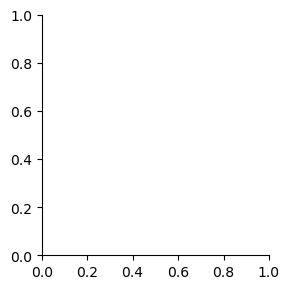

# Probit 1

In [39]:
model_label = 'probit1'
df, model, idata, gamma, rnp = get_info(model_label)

FileNotFoundError: [Errno 2] No such file or directory: b'/data/ds-riskeye/derivatives/cogmodels/model-probit1_trace.netcdf'

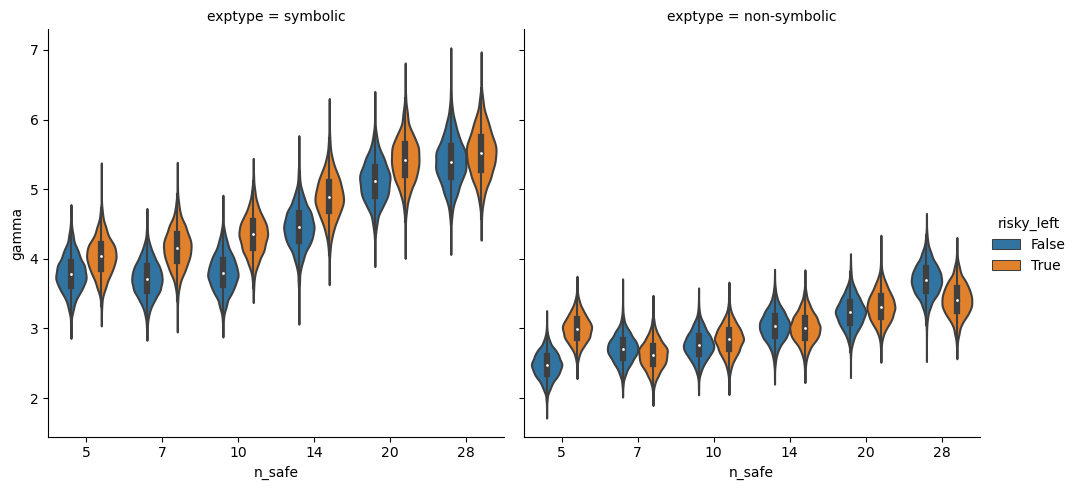

In [ ]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', hue='risky_left', col='exptype', kind='violin')

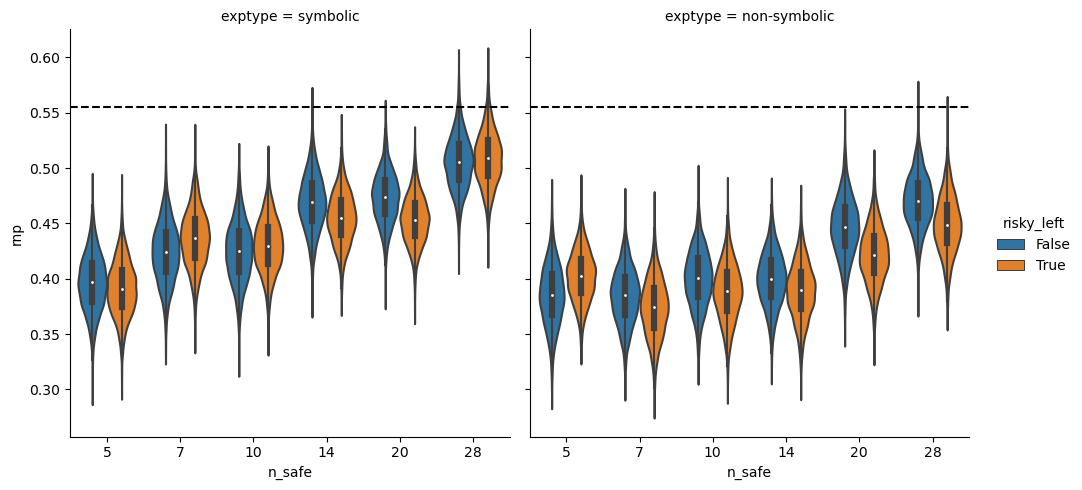

In [ ]:
g = sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', hue='risky_left', col='exptype', kind='violin')
g.map(lambda *args, **kwargs: plt.axhline(0.5555555, color='k', linestyle='--'))

diff
exptype      n_safe         
non-symbolic 5       0.00200
             7       0.66600
             10      0.33850
             14      0.56025
             20      0.33275
             28      0.90700
symbolic     5       0.15875
             7       0.03300
             10      0.01050
             14      0.06050
             20      0.14825
             28      0.34400

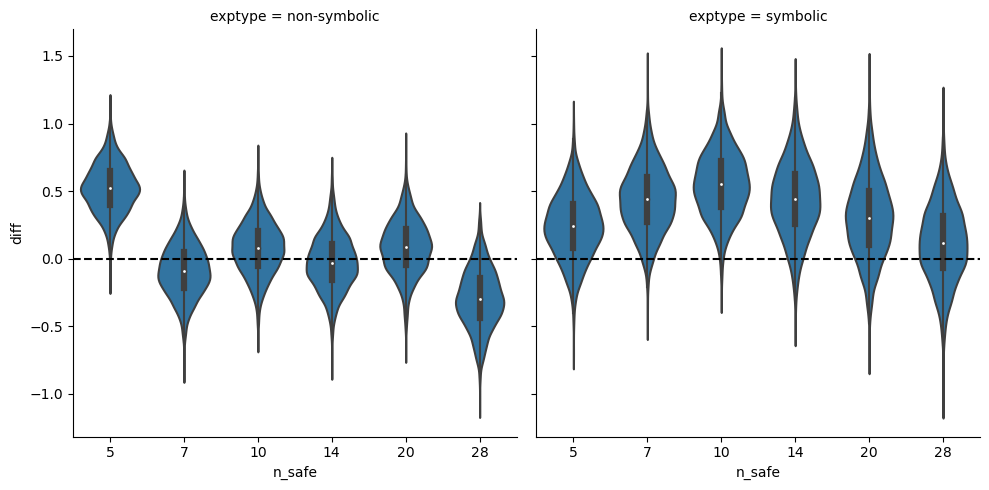

In [ ]:
tmp = gamma.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs(True, 0, level='risky_left') - tmp.xs(False, 0, level='risky_left')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

diff
exptype      n_safe         
non-symbolic 5       0.07775
             7       0.79925
             10      0.84325
             14      0.82750
             20      0.98775
             28      0.95950
symbolic     5       0.72075
             7       0.15875
             10      0.29450
             14      0.89950
             20      0.98225
             28      0.38025

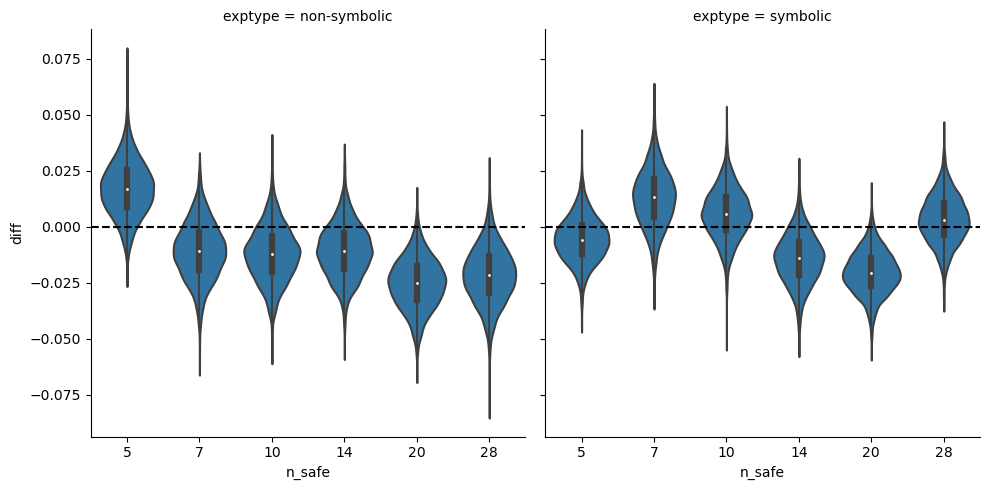

In [ ]:
tmp = rnp.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs(True, 0, level='risky_left') - tmp.xs(False, 0, level='risky_left')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

# Probit 2

In [ ]:
model_label = 'probit2'
df, model, idata, gamma, rnp = get_info(model_label)

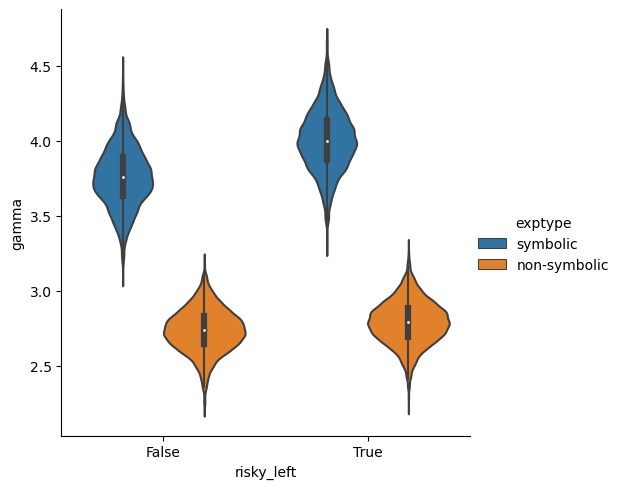

In [ ]:
import seaborn as sns
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='risky_left', y='gamma', hue='exptype', kind='violin')

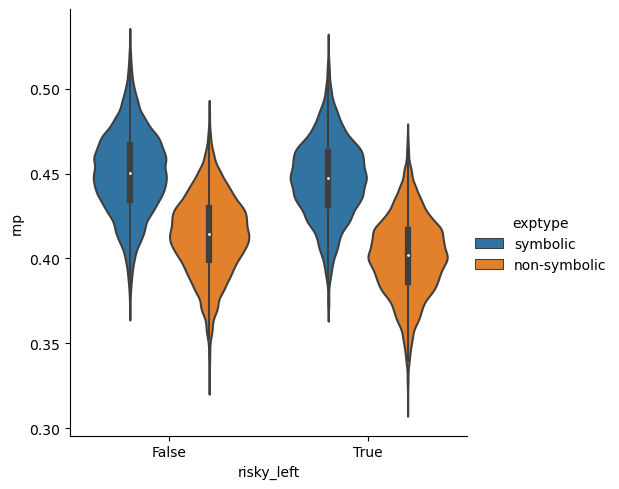

In [ ]:
import seaborn as sns
sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='risky_left', y='rnp', hue='exptype', kind='violin')

,diff
exptype,
non-symbolic,0.97450
symbolic,0.72075


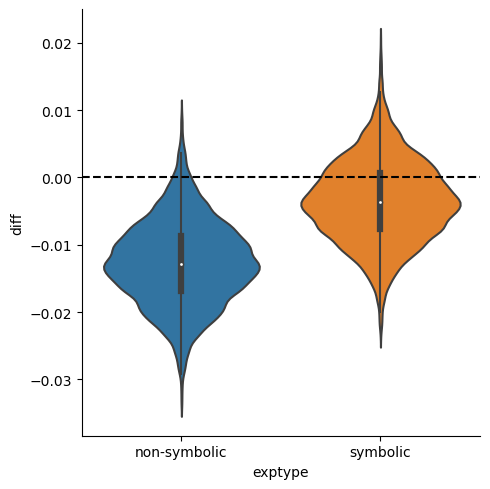

In [ ]:
tmp = rnp.stack([1,2]).unstack(['risky_left']).droplevel(0, 1)
diff = (tmp[True] - tmp[False]).to_frame('diff')
sns.catplot(x='exptype', y='diff', data=diff.reset_index(), kind='violin')
plt.axhline(0.0, c='k', ls='--')

diff.groupby(['exptype']).apply(lambda x: (x<0.0).mean())

# probit_risky_looked_at_first_simple

In [40]:
model_label = 'probit_risky_looked_at_first_simple'
df, model, idata, gamma, rnp = get_info(model_label)

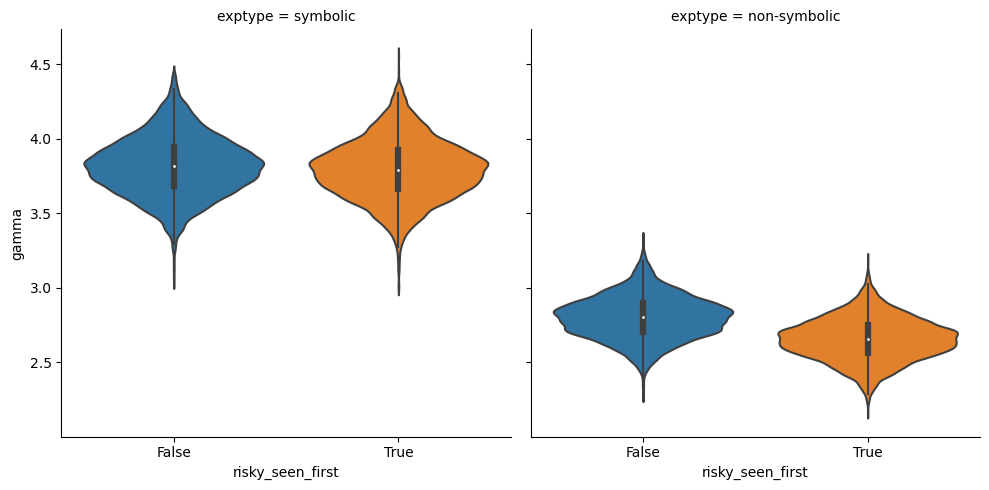

In [41]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), y='gamma', x='risky_seen_first', col='exptype', kind='violin')

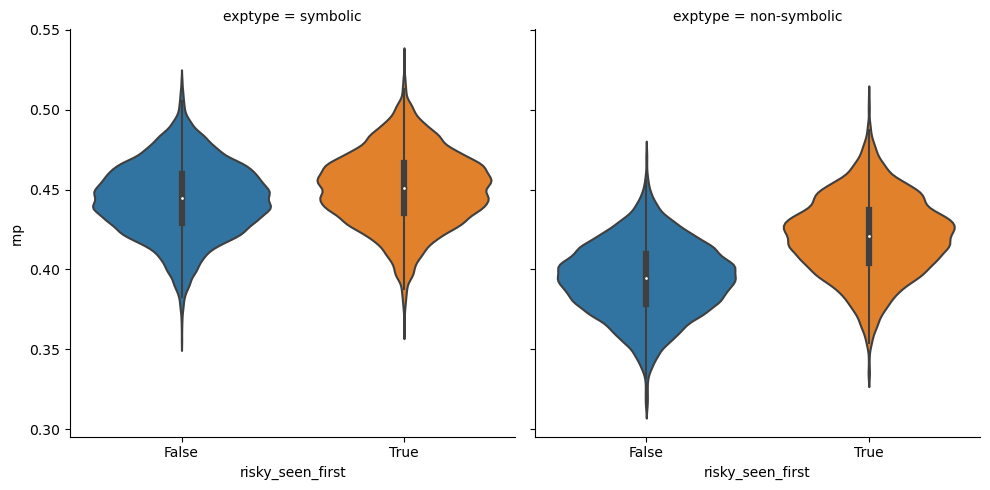

In [42]:
sns.catplot(data=rnp.stack([1, 2]).reset_index(), y='rnp', x='risky_seen_first', col='exptype', kind='violin')

,diff
exptype,
non-symbolic,0.0000
symbolic,0.1035


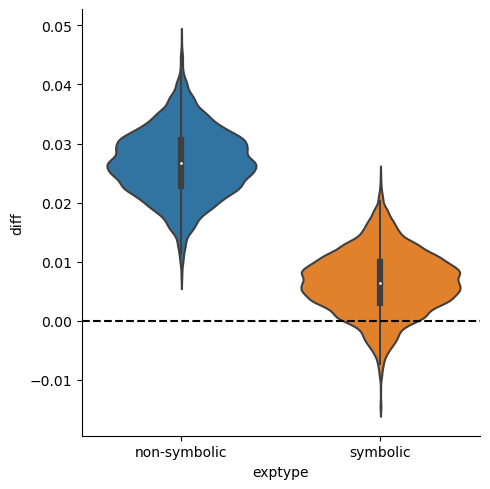

In [43]:
tmp = rnp.stack([1,2]).unstack(['risky_seen_first']).droplevel(0, 1)
diff = (tmp[True] - tmp[False]).to_frame('diff')
sns.catplot(x='exptype', y='diff', data=diff.reset_index(), kind='violin')
plt.axhline(0.0, c='k', ls='--')

diff.groupby(['exptype']).apply(lambda x: (x<0.0).mean())

# Probit first looked at

In [44]:
model_label = 'probit_risky_looked_at_first'
df, model, idata, gamma, rnp = get_info(model_label)

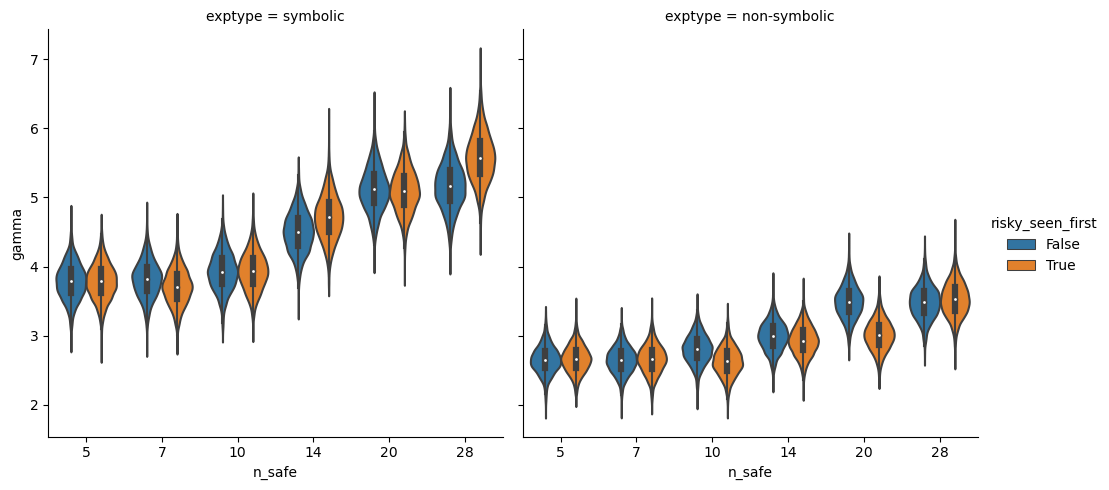

In [45]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', hue='risky_seen_first', col='exptype', kind='violin')

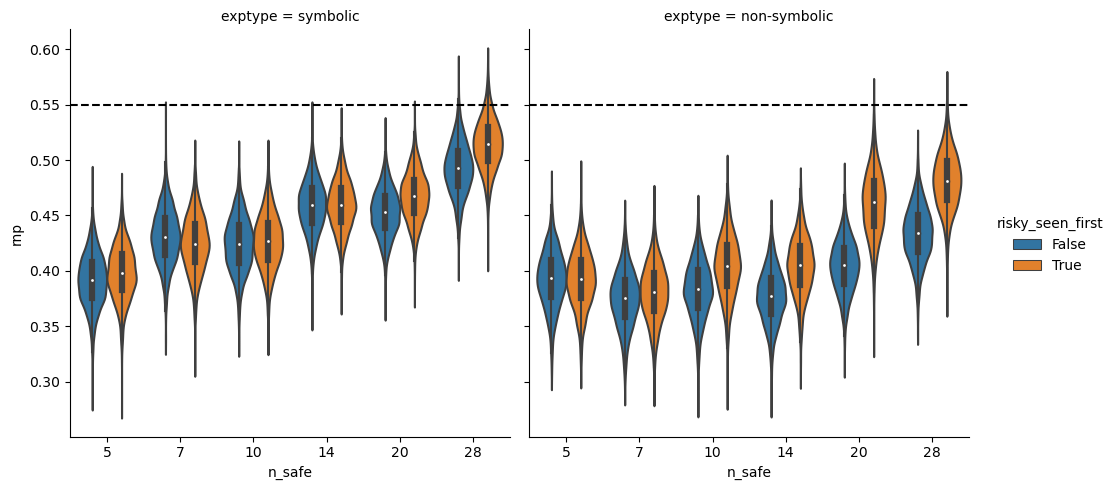

In [46]:
g = sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', hue='risky_seen_first', col='exptype', kind='violin')
g.map(lambda *args, **kwargs: plt.axhline(0.55, color='k', linestyle='--'))

diff
exptype      n_safe         
non-symbolic 5       0.52125
             7       0.31075
             10      0.04500
             14      0.01125
             20      0.00025
             28      0.00000
symbolic     5       0.25275
             7       0.71500
             10      0.41475
             14      0.48175
             20      0.06450
             28      0.02050

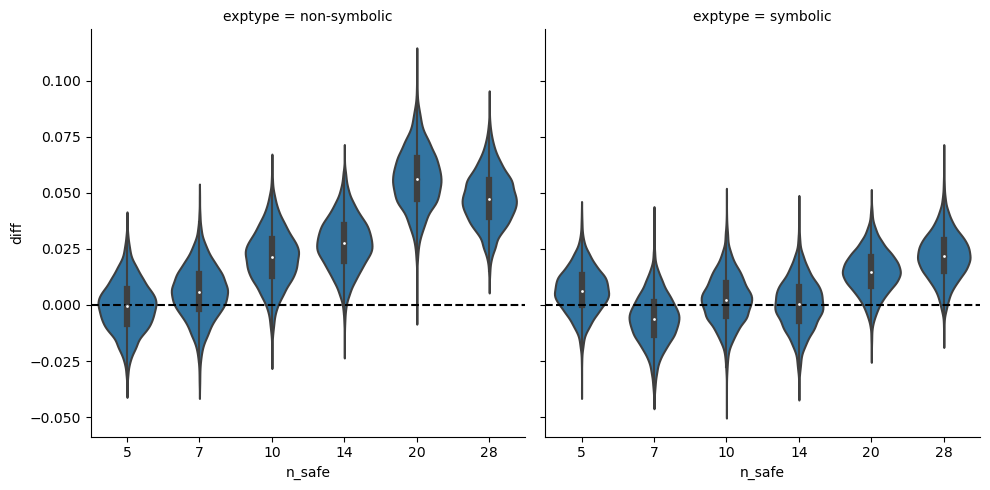

In [47]:
tmp = rnp.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs(True, 0, level='risky_seen_first') - tmp.xs(False, 0, level='risky_seen_first')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

diff
exptype      n_safe         
non-symbolic 5       0.47575
             7       0.47975
             10      0.80825
             14      0.62275
             20      0.98400
             28      0.42650
symbolic     5       0.50050
             7       0.68450
             10      0.49325
             14      0.24450
             20      0.54200
             28      0.07450

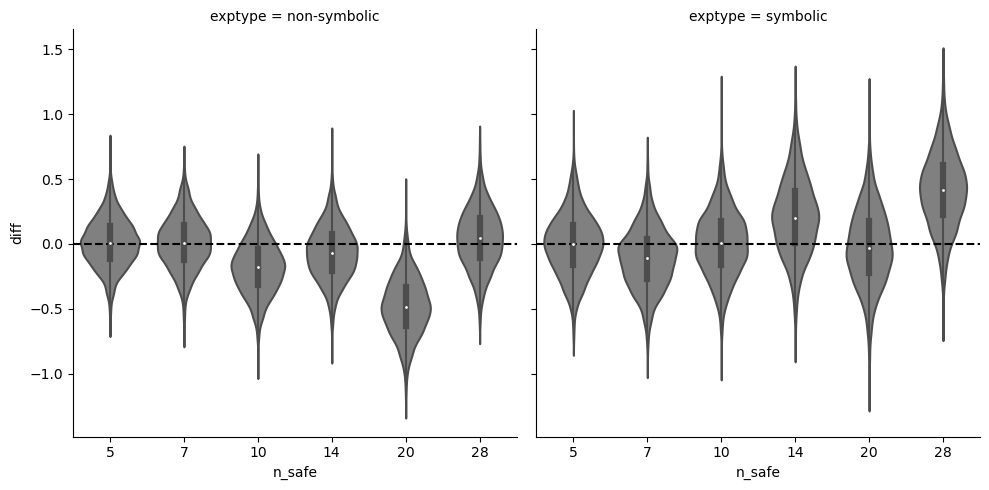

In [48]:
tmp = gamma.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs(True, 0, level='risky_seen_first') - tmp.xs(False, 0, level='risky_seen_first')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color='gray')
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))

tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

# Probit last looked at (simple)

In [49]:
model_label = 'probit_risky_looked_at_last_simple'
df, model, idata, gamma, rnp = get_info(model_label)

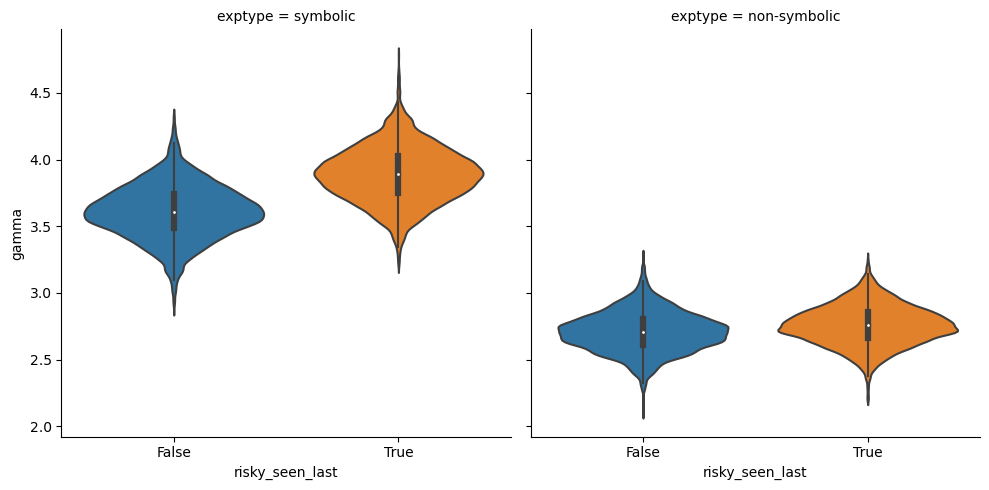

In [50]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), y='gamma', x='risky_seen_last', col='exptype', kind='violin')

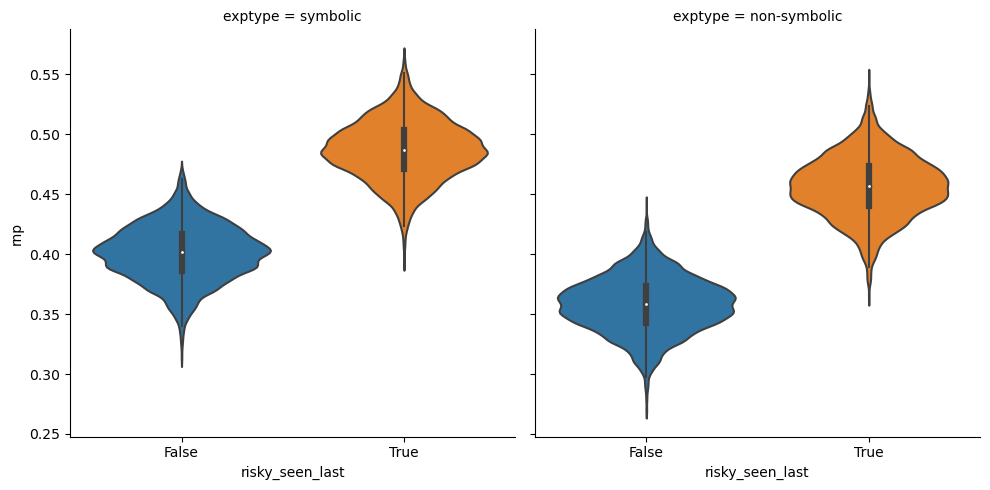

In [51]:
sns.catplot(data=rnp.stack([1, 2]).reset_index(), y='rnp', x='risky_seen_last', col='exptype', kind='violin')

# Probit last looked at

In [52]:
model_label = 'probit_risky_looked_at_last'
df, model, idata, gamma, rnp = get_info(model_label)

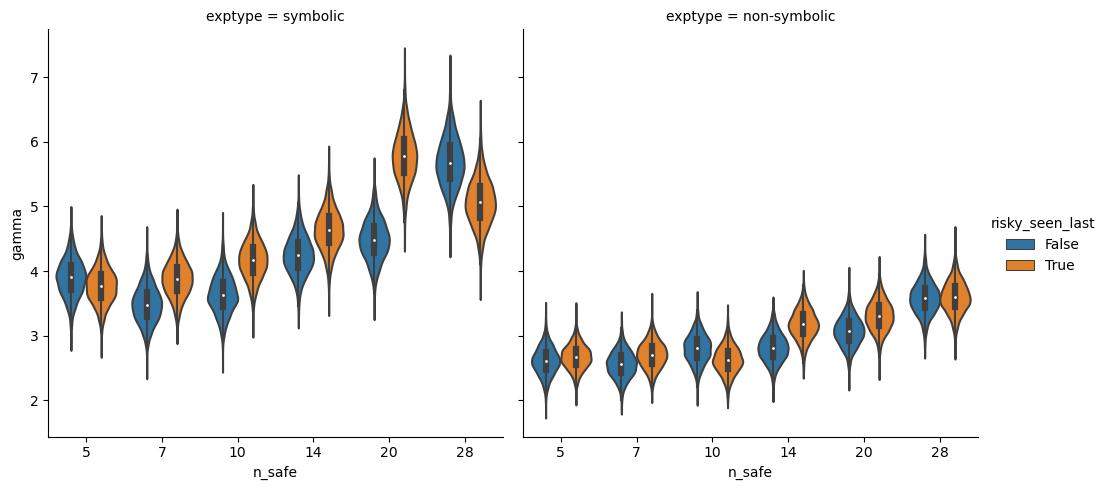

In [53]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', hue='risky_seen_last', col='exptype', kind='violin')

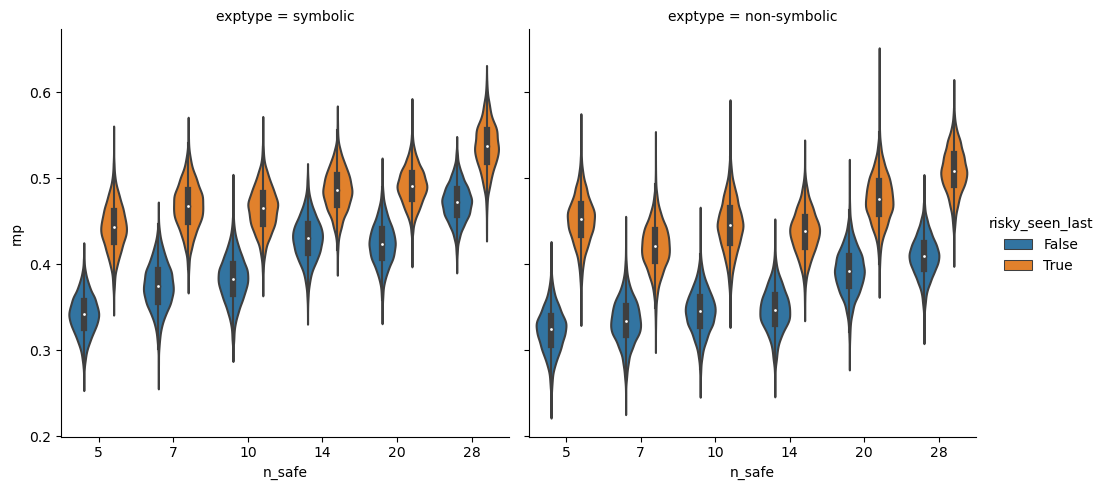

In [54]:
sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', hue='risky_seen_last', col='exptype', kind='violin')

diff
exptype      n_safe      
non-symbolic 5        0.0
             7        0.0
             10       0.0
             14       0.0
             20       0.0
             28       0.0
symbolic     5        0.0
             7        0.0
             10       0.0
             14       0.0
             20       0.0
             28       0.0

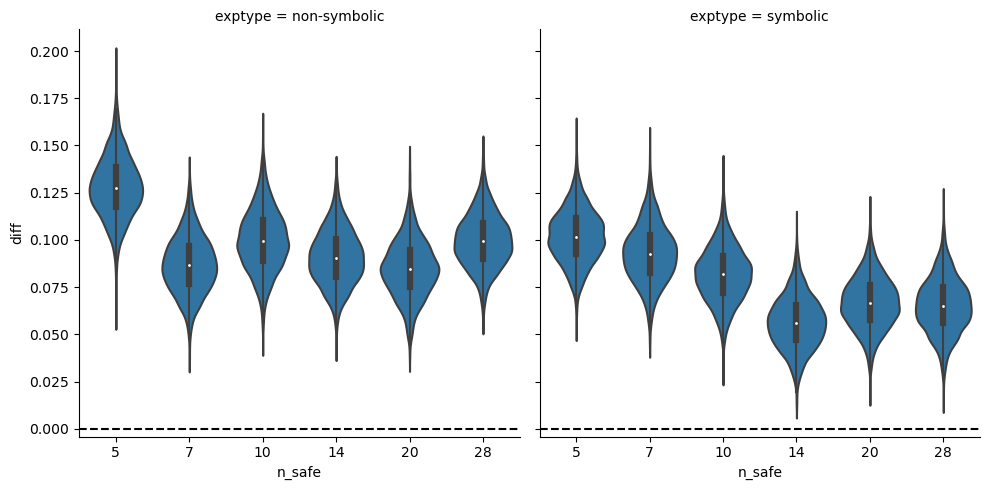

In [55]:
tmp = rnp.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs(True, 0, level='risky_seen_last') - tmp.xs(False, 0, level='risky_seen_last')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

# Probit proportion looked at risky option (simple)

In [56]:
model_label = 'probit_prop_looked_at_risky_simple'
df, model, idata, gamma, rnp = get_info(model_label)

OSError: [Errno -51] NetCDF: Unknown file format: b'/data/ds-riskeye/derivatives/cogmodels/model-probit_prop_looked_at_risky_simple_trace.netcdf'

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_85516/3025811428.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['risky_duration_prop'].to_dataframe())
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_85516/3025811428.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: ylabel='Density'>

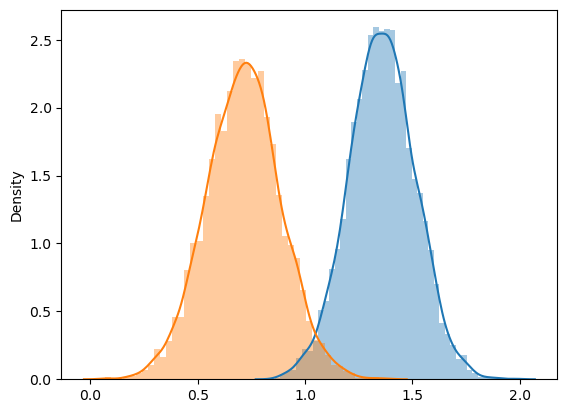

In [ ]:
sns.distplot(idata.posterior['risky_duration_prop'].to_dataframe())
sns.distplot(idata.posterior['risky_duration_prop'].to_dataframe() + idata.posterior['risky_duration_prop:exptype'].to_dataframe().values)

In [57]:
sns.distplot(idata.posterior['x:risky_duration_prop'].to_dataframe())
sns.distplot(idata.posterior['x:risky_duration_prop'].to_dataframe() + idata.posterior['x:risky_duration_prop:exptype'].to_dataframe().values)

KeyError: 'x:risky_duration_prop'